# **Emotion Recognition with CNN**
## Part 1 Project
## Jason Graham

---

## 1. Introduction
This project is created to recognize facial expressions using a cnn
- Dataset: Kaggle Face Expression Recognition
- Number of classes: 7 emotions (angry, disgust, fear, happy, neutral, sad, surprise)
- We will run the data through a simple three-block convolutional neural network before flattening to get results


## 2. Imports & Setup
Import the libraries we'll need.
As this course focuses on TensorFlow we will be using that but in the future, I believe I will be switching to PyTorch as TensorFlow no longer natively supports GPU usage on Windows, severely increasing the length of time required to train the models

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## 3. Data Loading and Exploration


In [5]:
# Define paths for training and validation datasets
train_dir = "./train"   
val_dir = "./val"       

# Find classes for dataset
class_names = os.listdir(train_dir)
print("Classes found in train_dir:", class_names)
print("Number of classes:", len(class_names))


Classes found in train_dir: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


## 4. Preprocessing
We'll use **ImageDataGenerator** to load images and rescale pixel values.


In [9]:
# Image size
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# For validation, we just rescale
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # used for multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Visualize a Few Images
This helps visually confirm the images were loaded successfully


Image batch shape: (32, 48, 48, 3)
Label batch shape: (32, 7)


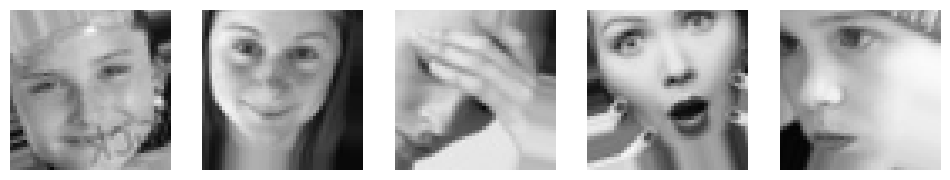

In [12]:
images, labels = next(train_generator)  # one batch of images
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

# Show a few images
fig, axes = plt.subplots(1, 5, figsize=(12,12))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis('off')
plt.show()


## 5. Build CNN Model
We define a simple CNN architecture
The initial 48x48 image resolution is passed through a convolutional layer with 32 filters and a 3x3 window size to enable the most out of the filter.
A normalization layer is also used after a few key points to pull values back into a usable range and hopefully allow useful information to shine through to the next layer.
We also used several pooling layers to ensure the strong signals reach through to the final layer and also to bring performance up


In [15]:
num_classes = len(class_names)  # e.g. 7

model = models.Sequential([
    # 1) Explicit Input layer
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # 2) First Convolution Block
    layers.ZeroPadding2D(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.ZeroPadding2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Normalization(),

    # 3) Second Convolution Block
    layers.ZeroPadding2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Normalization(),

    # 4) Third Convolution Block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Normalization(),

    # 5) Flatten + Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 50, 50, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 48, 48, 64)     │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 50, 50, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 24, 24, 64)     │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 10, 10, 128)    │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,917,706 (7.32 MB)

 Trainable params: 1,917,191 (7.31 MB)

 Non-trainable params: 515 (2.02 KB)

## 6. Train the Model


In [18]:
import math

steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(val_generator.samples / BATCH_SIZE)
EPOCHS=30

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Epoch 1/30


C:\Users\jason\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 205s 226ms/step - accuracy: 0.2381 - loss: 1.8311 - val_accuracy: 0.2581 - val_loss: 1.7779
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 166s 184ms/step - accuracy: 0.2481 - loss: 1.7926 - val_accuracy: 0.2952 - val_loss: 1.7444
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 155s 172ms/step - accuracy: 0.2653 - loss: 1.7711 - val_accuracy: 0.2995 - val_loss: 1.7015
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 142s 158ms/step - accuracy: 0.2833 - loss: 1.7445 - val_accuracy: 0.3269 - val_loss: 1.6745
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.3029 - loss: 1.7058 - val_accuracy: 0.3736 - val_loss: 1.5702
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.3362 - loss: 1.6438 - val_accuracy: 0.4267 - val_loss: 1.4716
Epoch 7/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.3724 - loss: 1.5716 - val_accuracy: 0.4601 - val_loss: 1.3998
Epoch 8/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 324s 360ms/step - accuracy: 0.4114 - loss: 1.50

### Plot Accuracy and Loss Curves


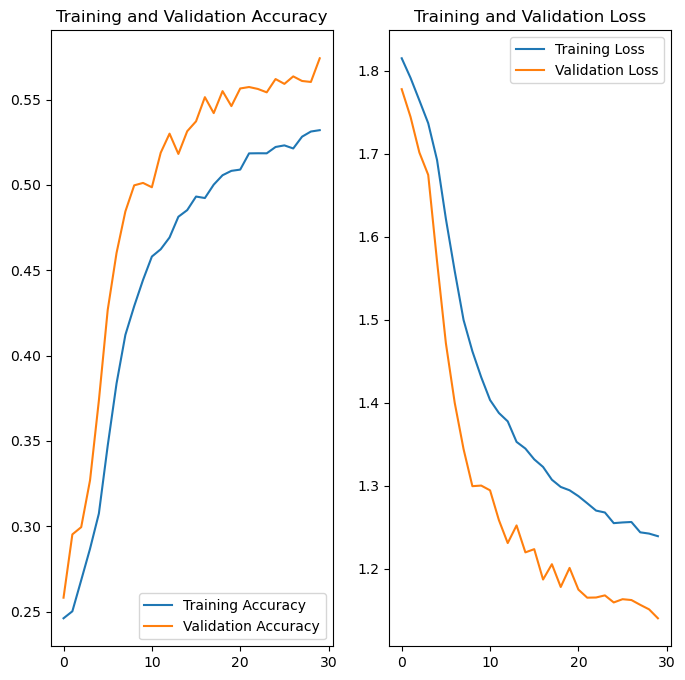

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## 7. Evaluation & Confusion Matrix
We run predictions on the validation set, then create a confusion matrix to see how well the model did.


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(
    rescale=1./255
    # no augmentation for validation
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # <--- IMPORTANT
)


Found 7066 images belonging to 7 classes.


C:\Users\jason\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step
Confusion Matrix:
 [[ 468    0   49   57  184  163   39]
 [  69    0    3    2   12   18    7]
 [ 195    0  141   69  195  227  191]
 [  60    0   18 1534  105   58   50]
 [  68    0   37  107  817  148   39]
 [ 132    0   49   91  364  474   29]
 [  26    0   51   49   37   11  623]]


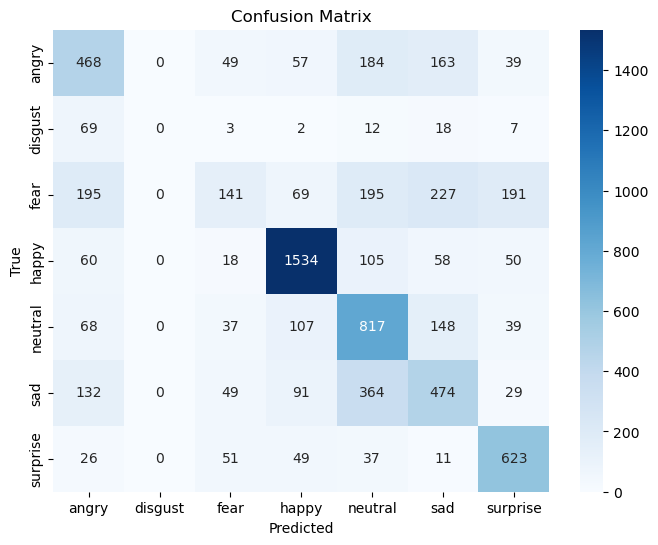

              precision    recall  f1-score   support

       angry       0.46      0.49      0.47       960
     disgust       0.00      0.00      0.00       111
        fear       0.41      0.14      0.21      1018
       happy       0.80      0.84      0.82      1825
     neutral       0.48      0.67      0.56      1216
         sad       0.43      0.42      0.42      1139
    surprise       0.64      0.78      0.70       797

    accuracy                           0.57      7066
   macro avg       0.46      0.48      0.45      7066
weighted avg       0.55      0.57      0.55      7066



C:\Users\jason\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jason\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jason\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure we start from the first batch
val_generator.reset()

# Use model.predict on the entire validation set, without steps=...
preds = model.predict(val_generator, verbose=1)

# Convert logits to predicted class indices
predicted_class_indices = np.argmax(preds, axis=1)

# True labels from the generator (all images)
true_class_indices = val_generator.classes

# Get the class label order from the generator
label_map = val_generator.class_indices  

# Sort label_map keys by their numeric index
class_labels = sorted(label_map.keys(), key=lambda x: label_map[x])

# Build confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report = classification_report(true_class_indices, predicted_class_indices,
                               target_names=class_labels)
print(report)


## 8. Conclusion

- We obtained an overall accuracy of ~%55 by the conclusion of 30 Epochs.
- In the confusion matrix we observed that the simpler emotions (Happy, Neutral, Sad, Surprise, Angry) received the highest levels of confidence in the data gathered the more complex and multifaceted emotions (Anger, Disgust, Fear) struggled immensely to be properly recognized with disgust utterly failing to be recognized.
- The networks topology may not be ideal for the task
